In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import statistics

In [42]:
start_date="2022-08-01"
end_date="2023-07-30"
# start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
# end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
tickers=("JPM","AAPL","BAC")
data=yf.download(tickers,start=start_date,end=end_date)["Adj Close"]
data

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,BAC,JPM
Date,,,
2022-08-01,159.703156,31.869627,108.613457
2022-08-02,158.219940,31.236204,106.920677
2022-08-03,164.271515,31.803442,108.042862
2022-08-04,163.955048,31.576550,106.854118
2022-08-05,163.727325,32.105976,110.087509
...,...,...,...
2023-07-24,191.731766,31.706228,154.977463
2023-07-25,192.597168,31.220680,153.820053
2023-07-26,193.472519,31.473164,154.742050


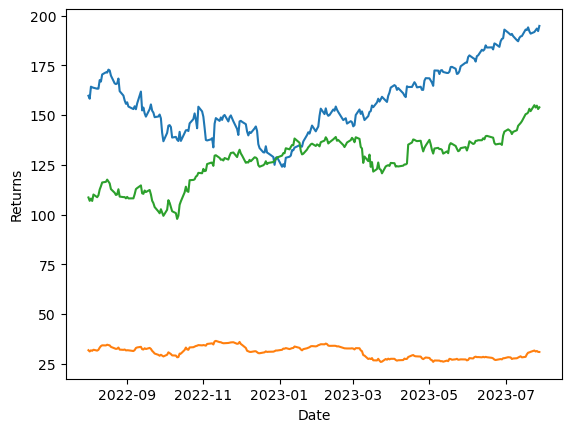

In [43]:
plt.plot(data)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()


The above graph represents that the data is non-stationary, as we can clearly see a trend. We can further verify statistaclly using Augmented Dickey-Fuller test. 
We used the differential method to get stationarity in the data

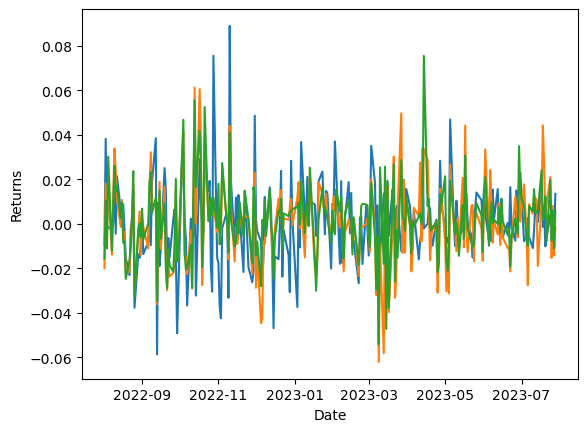

Augmented Dickey-Fuller Test: AAPL
ADF Statistic: -7.323087
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

Augmented Dickey-Fuller Test: BAC
ADF Statistic: -13.984874
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

Augmented Dickey-Fuller Test: JPM
ADF Statistic: -15.407725
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573



In [226]:
from statsmodels.tsa.stattools import adfuller
# COnverting non-stationary data to satationary data
returns=data.pct_change().dropna()

# Plotting line graph to check stationarity
plt.plot(returns,)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Statistical test to check stationarity using Augemented Dickey-fuller test 
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

# Apply ADF test to each stock's returns
for column in returns.columns:
    adf_test(returns[column], title=column)

As p value in all the stocks is <0.05 we reject null hypothesis and xonclude that the data is stationary. Also, same can be visualized in above graph

# Calculate VaR using Variance-Covariance Method

In [5]:
# weights of portfolio
w1=0.30
w2=0.40
w3=0.30
weights=np.array([w1,w2,w3])
invested_amt=1000000
s1_value=invested_amt*w1
s2_value=invested_amt*w2
s3_value=invested_amt*w3
# Caculate portfolio return

wt_returns=returns*weights
R_p=wt_returns.sum(axis=1)
port_mean=R_p.mean()
print(f"Mean Return of the portfolio is {round((port_mean*100),2)}%")

print(f"Invested amount in AAPL is ${s1_value}")
print(f"Invested amount in JPM is ${s2_value}")
print(f"Invested amount in BAC is ${s3_value}")

Mean Return of the portfolio is 0.08%
Invested amount in AAPL is $300000.0
Invested amount in JPM is $400000.0
Invested amount in BAC is $300000.0


In [51]:
returns

Ticker,AAPL,BAC,JPM
Date,,,
2022-08-02,-0.009287,-0.019875,-0.015585
2022-08-03,0.038248,0.018160,0.010495
2022-08-04,-0.001926,-0.007134,-0.011003
2022-08-05,-0.001389,0.016766,0.030260
2022-08-08,-0.002903,-0.013840,-0.012180
...,...,...,...
2023-07-24,0.004220,0.020951,0.019684
2023-07-25,0.004514,-0.015314,-0.007468
2023-07-26,0.004545,0.008087,0.005994


In [152]:
# Portfoio std. dev
import numpy as np
covar=returns.cov()
port_variance=np.dot(weights.T,np.dot(weights,covar))
std_port=np.sqrt(port_variance)
std_port


0.0006600834134509555

In [241]:
# Calculate var using Var-covar method
import scipy.stats
ci_varcovar=[0.99,0.95,0.90]
var_value_varcovar=[]
for confidence in ci_varcovar:
    alpha = 1 - confidence
    z_value = scipy.stats.norm.ppf(alpha)
    var_p = ((port_mean +(std_port *z_value)) * invested_amt)
    var_value_varcovar.append((confidence,var_p))
    print(f"The 1-day VaR for portfolio at {confidence*100:.0f}% CI is: ${var_p}")


The 1-day VaR for portfolio at 99% CI is: $-766.3026970868531
The 1-day VaR for portfolio at 95% CI is: $-316.45964822091383
The 1-day VaR for portfolio at 90% CI is: $-76.64998341369719


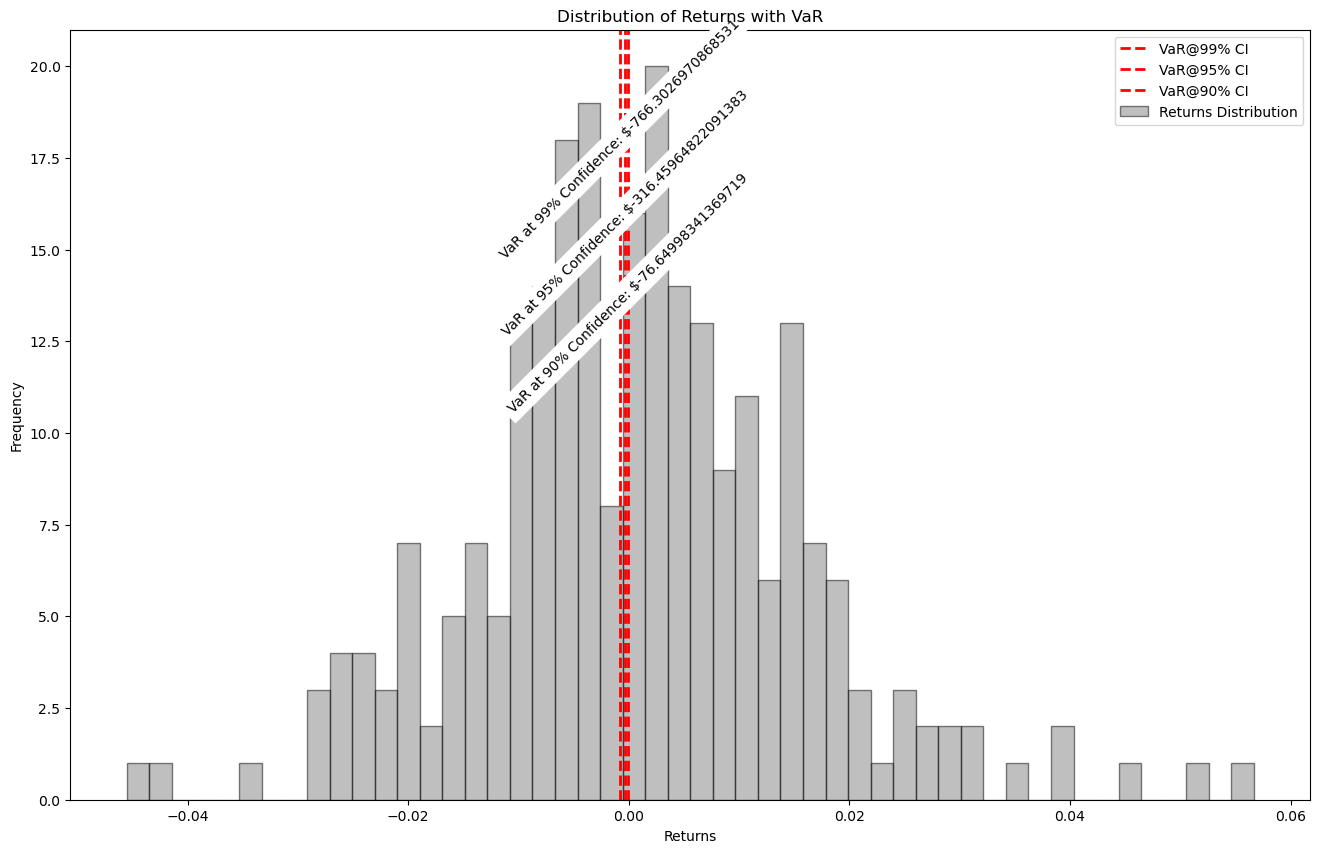

In [243]:
# Convert VaR values to DataFrame for plotting
VaR = pd.DataFrame(var_value, columns=['Confidence Level', 'VaR'])

# Plot the distribution of returns
plt.figure(figsize=(16, 10))
plt.hist(R_p, bins=50, color='grey', alpha=0.5, edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns with VaR')

# Add VaR lines and labels
y_positions = [0.7, 0.6, 0.5]
for i, (ci, var) in enumerate(var_value_varcovar):
    plt.axvline(x=var / invested_amt, color='red', linestyle='--', linewidth=2)
    label = f'VaR at {ci*100:.0f}% Confidence: ${var}'
    y_position = plt.ylim()[1] * y_positions[i]  
    plt.text(var / invested_amt, y_position, label, color='black', ha='center', va='bottom', rotation=45, backgroundcolor='white')
plt.legend(['VaR@99% CI', 'VaR@95% CI', 'VaR@90% CI', 'Returns Distribution'])
plt.show()


# VaR calculation using Historical Method

In [115]:
wt_returns=R_p.sort_values()
wt_returns.head(5)

Date
2023-03-09   -0.043260
2022-09-13   -0.042714
2022-08-26   -0.033665
2022-12-15   -0.028863
2023-03-17   -0.027368
dtype: float64

In [153]:
ranks=wt_returns.rank()
ranks.head(5)

Date
2023-03-09    1.0
2022-09-13    2.0
2022-08-26    3.0
2022-12-15    4.0
2023-03-17    5.0
dtype: float64

In [155]:
def value_at_rank(returns, ranks, position):
        index = ranks[ranks == position].index[0]
        # Get the value at that index
        values = returns.loc[index]
        return values
ci_hm=[0.99,0.95,0.90]
VaR_values=[]
for confidence in ci_hm:
    position=round(len(wt_returns)*(1-confidence))
    position_value=value_at_rank(wt_returns,ranks,position)
    VaR_p=round(position_value*invested_amt,2)
    VaR_values.append((confidence, VaR_p))
    print(f"The 1-day VaR for portfolio at {confidence*100:.0f}% CI is: ${VaR_p}")


The 1-day VaR for portfolio at 99% CI is: $-42713.96
The 1-day VaR for portfolio at 95% CI is: $-22488.1
The 1-day VaR for portfolio at 90% CI is: $-17823.56


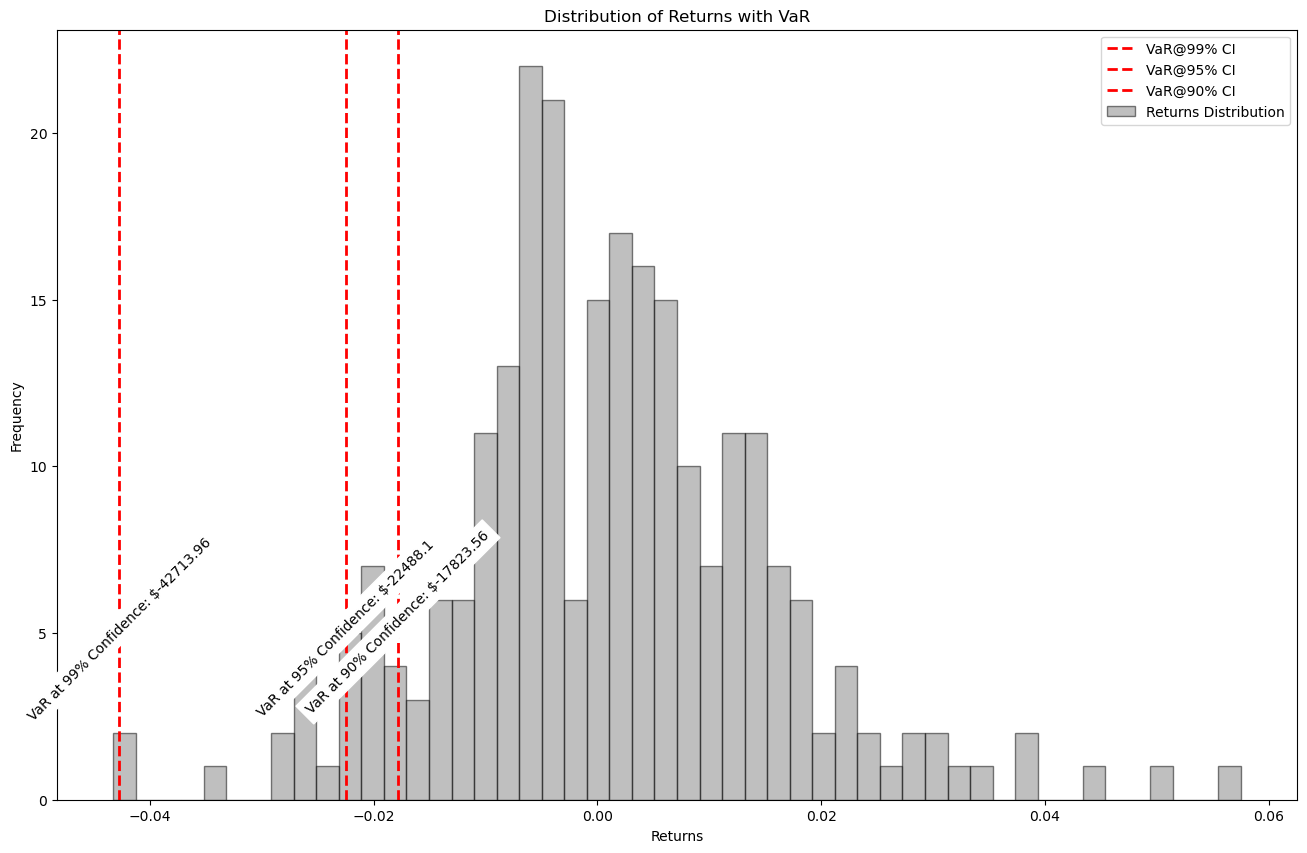

In [192]:
# Convert VaR values to DataFrame for plotting
VaR_df = pd.DataFrame(VaR_values, columns=['Confidence Level', 'VaR'])

# Plot the distribution of returns
plt.figure(figsize=(16, 10))
plt.hist(wt_returns, bins=50, color='grey', alpha=0.5, edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns with VaR')

# Add VaR lines and labels
for ci, var in VaR_values:
    plt.axvline(x=var / invested_amt, color='red', linestyle='--', linewidth=2)
    label = f'VaR at {ci*100:.0f}% Confidence: ${var}'
    y_position = plt.ylim()[1] * 0.1 + 0.1 * (ci_hm.index(ci))  # Slightly different y position for each label
    plt.text(var / invested_amt, y_position, label, color='black', ha='center', va='bottom', rotation=45, backgroundcolor='white')
plt.legend(['VaR@99% CI', 'VaR@95% CI', 'VaR@90% CI', 'Returns Distribution'])
plt.show()


In [116]:
data.shape[1]

3

# VaR calculation using Monte Carlo Simulation

In [127]:
# Generate uncorrelated random variable using Normal distribution
mean=0.0
std_dev=1.0
size=1000
num_lists=data.shape[1]

rv = np.random.normal(loc=mean, scale=std_dev, size=(size, num_lists))

# Assign the lists to the variable rv

rv

array([[-0.72978707,  1.61118535, -0.37923049],
       [ 0.02519346, -0.94137915,  1.22593943],
       [-0.82535384,  0.536251  ,  0.70029525],
       ...,
       [-0.07795497,  0.74808352, -0.12520733],
       [-0.20818816, -0.5887812 , -0.45397854],
       [-0.27873495, -0.05045982,  0.20213315]])

In [128]:
# Correlation matrix of the random variable
corr_matrix=np.corrcoef(rv,rowvar=False)
corr_matrix

array([[ 1.        , -0.00216984, -0.00962928],
       [-0.00216984,  1.        , -0.01914941],
       [-0.00962928, -0.01914941,  1.        ]])

In [129]:
# Cholesky decomposition(cd) to get correlated matrix
cd_matrix= np.linalg.cholesky(corr_matrix)
cd_matrix

array([[ 1.        ,  0.        ,  0.        ],
       [-0.00216984,  0.99999765,  0.        ],
       [-0.00962928, -0.01917035,  0.99976986]])

In [130]:
correlated_rv=np.dot(rv,cd_matrix.T)
correlated_rv

array([[-0.72978707,  1.61276508, -0.40300287],
       [ 0.02519346, -0.9414316 ,  1.24346127],
       [-0.82535384,  0.53804063,  0.69780152],
       ...,
       [-0.07795497,  0.74825091, -0.13876888],
       [-0.20818816, -0.58832808, -0.44058222],
       [-0.27873495, -0.04985489,  0.20573799]])

In [131]:
import statistics as st
mu=0.04 #risk free rate r_f, drift term
sigma=returns.std() #volatility of  each stock 
s0=data.iloc[-1] #Spot price of the stock
T=1 #in years
# (end_date-start_date)/365
dt=T/size
t = np.linspace(0, T, size)

In [134]:
simulation=np.zeros((size, num_lists))
for i in range(size):
    t_i=i*dt
    for j in range(num_lists):
        s_t=s0[j]* np.exp((mu-(0.5*(sigma[j]**2)))*t_i+ sigma[j]*correlated_rv[i,j])
        simulation[i,j]=s_t

C:\Users\bd512\AppData\Local\Temp\ipykernel_21200\2956767513.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_t=s0[j]* np.exp((mu-(0.5*(sigma[j]**2)))*t_i+ sigma[j]*correlated_rv[i,j])


In [135]:
simulation

array([[192.22472382,  31.90453834, 152.89981065],
       [194.8926238 ,  30.45069572, 157.06840444],
       [191.90588664,  31.28650302, 155.68269997],
       ...,
       [202.40001141,  32.67670144, 159.78683572],
       [201.9287757 ,  31.88945829, 159.00840385],
       [201.67764936,  32.2061105 , 160.70016556]])

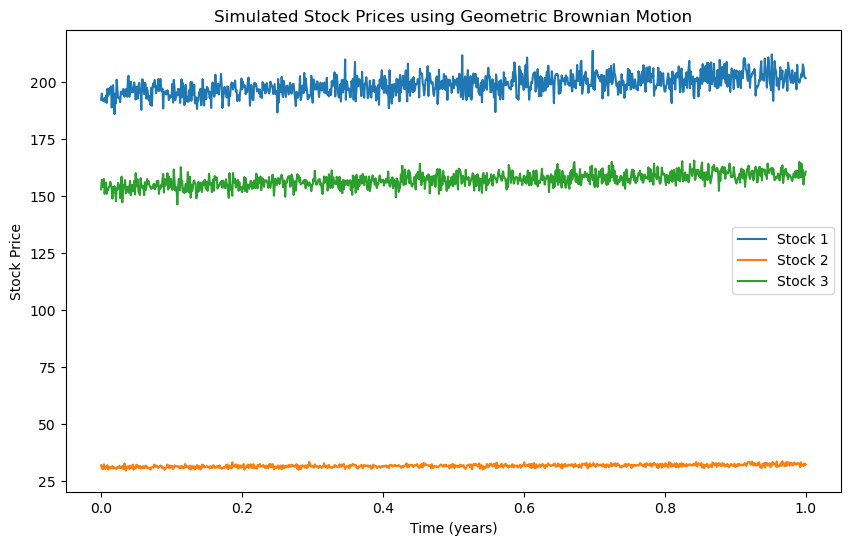

In [136]:
# Plot the simulated stock prices
plt.figure(figsize=(10, 6))
for i in range(num_lists):
    plt.plot(t, simulation[:, i], label=f'Stock {i+1}')
plt.title('Simulated Stock Prices using Geometric Brownian Motion')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [209]:
# Convert simulation results to DataFrame
simulation_df = pd.DataFrame(simulation, columns=data.columns)
log_return=np.log(simulation_df/simulation_df.shift(1)).dropna()
port_return= (log_return*weights).sum(axis=1)
port_return

1     -0.000148
2      0.000081
3     -0.000729
4      0.001355
5     -0.001173
         ...   
995    0.000544
996   -0.000908
997    0.000744
998   -0.000490
999    0.000294
Length: 999, dtype: float64

In [221]:
port_return_sorted=port_return.sort_values(ascending=True)
port_rank=port_return_sorted.rank(method='first').astype(int)
port_rank = pd.DataFrame({'Rank': port_rank,
   'Return': port_return_sorted
}).reset_index(drop=True)

port_rank

,Rank,Return
0,1,-0.001733
1,2,-0.001718
2,3,-0.001706
3,4,-0.001682
4,5,-0.001630
...,...,...
994,995,0.001653
995,996,0.001708
996,997,0.001743
997,998,0.001748


In [236]:
#VaR using Monte carlo simulation
def value_at_rank_mc(returns,ranks, position_mc):
        index = ranks[ranks == position_mc].index[0]
        # Get the value at that index
        values = returns.loc[index]
        return values
ci_mc=[0.99,0.95,0.90]
VaR_values=[]
for confidence in ci_mc:
    count_return= port_rank['Return'].count()
    alpha=1-confidence
    position_mc=round(count_return*(1-confidence),0)
    position_value_mc=value_at_rank_mc(port_rank['Return'],port_rank['Rank'],position_mc)
    VaR_p=round(position_value_mc*invested_amt,2)
    VaR_values.append((confidence, VaR_p))
    print(f"The 1-day VaR for portfolio at {confidence*100:.0f}% CI is: ${VaR_p}")


The 1-day VaR for portfolio at 99% CI is: $-1455.57
The 1-day VaR for portfolio at 95% CI is: $-998.22
The 1-day VaR for portfolio at 90% CI is: $-796.89


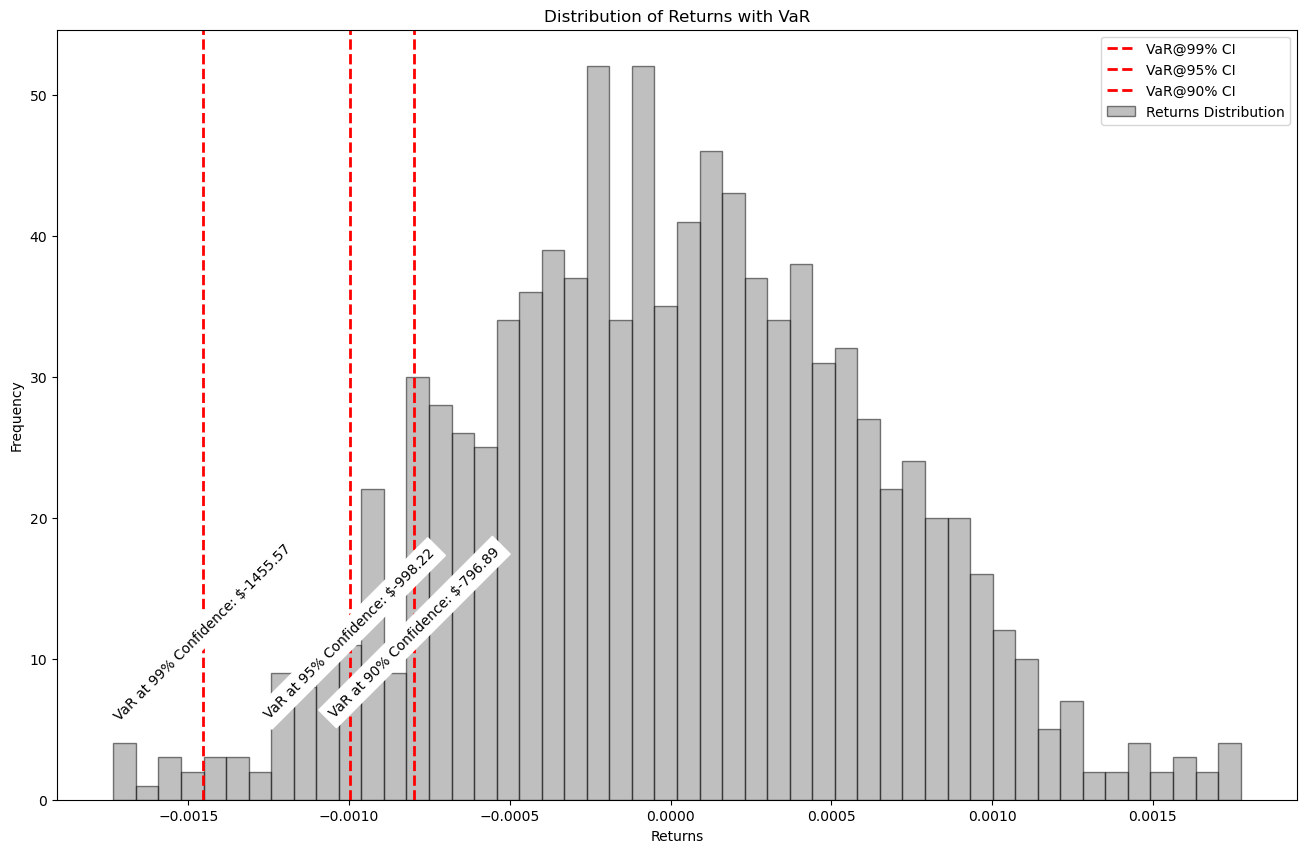

In [237]:
# Convert VaR values to DataFrame for plotting
VaR = pd.DataFrame(VaR_values, columns=['Confidence Level', 'VaR'])

# Plot the distribution of returns
plt.figure(figsize=(16, 10))
plt.hist(port_return, bins=50, color='grey', alpha=0.5, edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns with VaR')
# Add VaR lines and labels
for ci, var in VaR_values:
    plt.axvline(x=var / invested_amt, color='red', linestyle='--', linewidth=2)
    label = f'VaR at {ci * 100:.0f}% Confidence: ${var:.2f}'
    y_position = plt.ylim()[1] * 0.1 + 0.1 * (ci_mc.index(ci))  
    plt.text(var / invested_amt, y_position, label, color='black', ha='center', va='bottom', rotation=45, backgroundcolor='white')

plt.legend(['VaR@99% CI', 'VaR@95% CI', 'VaR@90% CI', 'Returns Distribution'])
plt.show()